<a href="https://colab.research.google.com/github/cristinarainich/Sternberg_analysis/blob/main/iEEG_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
import pandas as pd
import numpy as np
from pathlib import Path
import pylab as pl
import seaborn as sns
import re
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [121]:
!pip install -q pymer4

In [122]:
from pymer4.models import Lmer

In [79]:
sns.set()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
working_path = Path('/content/drive/MyDrive/CoganLab')

In [4]:
ieeg = pd.read_csv(
    working_path.joinpath('ieeg_all.csv'),
    index_col=None
)

# Preprocessing

In [5]:
ieeg.columns

Index(['Unnamed: 0', 'block', 'ProbeType', 'ProbeTypeName', 'StimlusCategory',
       'ReactionTime', 'KeyCode', 'Resp', 'RespCorrect', 'Omission',
       'stimulusAudioStart', 'stimulusAlignedTrigger', 'probeAudioStart',
       'probeAlignedTrigger', 'TriggerValue', 'stimulusSounds_idx',
       'stimulusSounds_name', 'ProbeCategory', 'probeSound_idx',
       'probeSound_name', 'Trial', 'Subject', 'ListenCueTime',
       'MaintenancePeriodTime', 'ProbeCueTime'],
      dtype='object')

In [6]:
ieeg = ieeg.loc[:, ieeg.columns != 'Unnamed: 0'] # some extra column appeared while uploading data

In [7]:
ieeg.isnull().sum()

block                       0
ProbeType                   0
ProbeTypeName               0
StimlusCategory             0
ReactionTime                0
KeyCode                     0
Resp                        0
RespCorrect                 0
Omission                  160
stimulusAudioStart          0
stimulusAlignedTrigger      0
probeAudioStart             0
probeAlignedTrigger         0
TriggerValue                0
stimulusSounds_idx          0
stimulusSounds_name         0
ProbeCategory               0
probeSound_idx              0
probeSound_name             0
Trial                       0
Subject                     0
ListenCueTime             953
MaintenancePeriodTime     953
ProbeCueTime              953
dtype: int64

In [12]:
ieeg.shape

(4820, 24)

In [18]:
ieeg_subset = ieeg[[
                 'Trial', 'Subject', 'block', 'ProbeType', 'probeSound_idx',
                 'ProbeTypeName', 'StimlusCategory', 'ReactionTime', 'KeyCode',
                 'Resp', 'RespCorrect', 'Omission', 'ProbeCategory',
                  'stimulusSounds_idx'                 
]]

In [19]:
ieeg_subset.head()

,Trial,Subject,block,ProbeType,probeSound_idx,ProbeTypeName,StimlusCategory,ReactionTime,KeyCode,Resp,RespCorrect,Omission,ProbeCategory,stimulusSounds_idx
0,0,D23,1,2,29,in_sequence,Low Words,0.857518,37,Yes,1,Responded,Low Words,[[29 25 30]]
1,1,D23,1,2,5,in_sequence,High Words,1.339604,37,Yes,1,Responded,High Words,[[ 2 5 8 4 7 10 3]]
2,2,D23,1,2,16,in_sequence,High Non-Words,1.045657,37,Yes,1,Responded,High Non-Words,[[19 14 18 16 20 15 17]]
3,3,D23,1,1,29,out_of_sequence,High Words,1.497001,39,No,1,Responded,Low Words,[[10 2 7 9 1 8 6 5 4]]
4,4,D23,1,1,9,out_of_sequence,Low Words,1.679783,39,No,1,Responded,High Words,"[30, 24, 25, 29, 21]"


In [23]:
ieeg[ieeg['Omission'] == 'No Response']

,block,ProbeType,ProbeTypeName,StimlusCategory,ReactionTime,KeyCode,Resp,RespCorrect,Omission,stimulusAudioStart,...,stimulusSounds_idx,stimulusSounds_name,ProbeCategory,probeSound_idx,probeSound_name,Trial,Subject,ListenCueTime,MaintenancePeriodTime,ProbeCueTime
9,1,2,in_sequence,Low Non-words,2.502478,[[37 39 32 27]],No Response,0,No Response,[[1303859.8880887 ]\n [1303860.88677856]\n [13...,...,[[32 37 31 39 40 35 33 38 36]],"[[array(['faez.wav'], dtype='<U8')]\n [array([...",Low Non-words,39,yuwf.wav,9,D23,NaN,NaN,NaN
19,1,1,out_of_sequence,High Non-Words,2.502283,[[37 39 32 27]],No Response,0,No Response,[[1304003.21244405]\n [1304004.21112077]\n [13...,...,[[17 19 18 13 15 12 16]],"[[array(['puwn.wav'], dtype='<U8')]\n [array([...",Low Non-Words,40,zerth.wav,19,D23,NaN,NaN,NaN
26,1,1,out_of_sequence,High Non-Words,2.502340,[[37 39 32 27]],No Response,0,No Response,[[1304094.6675821 ]\n [1304095.66614558]\n [13...,...,[[13 18 14]],"[[array(['kawl.wav'], dtype='<U8')]\n [array([...",Low Non-Words,33,gawth.wav,26,D23,NaN,NaN,NaN
32,2,2,in_sequence,Low Words,2.502395,[[37 39 32 27]],No Response,0,No Response,[[1304244.82254705]\n [1304245.82117574]\n [13...,...,[[30 22 25 29 21 23 24 28 27]],"[[array(['youth.wav'], dtype='<U9')]\n [array(...",Low Words,25,sure.wav,32,D23,NaN,NaN,NaN
97,4,1,out_of_sequence,High Non-Words,2.502652,[[37 39 32 27]],No Response,0,No Response,[[1305123.68254147]\n [1305124.68119027]\n [13...,...,[[16 17 18]],"[[array(['paon.wav'], dtype='<U8')]\n [array([...",Low Non-Words,36,vern.wav,97,D23,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4665,1,2,in_sequence,High Words,2.502103,"[114, 115, 66, 10, 27]",No Response,0,No Response,[[1.65082281e+09]\n [1.65082281e+09]\n [1.6508...,...,[[10 5 7 1 3 8 6 9 2]],"[[array(['witch.wav'], dtype='<U9')]\n [array(...",High Words,5,lair.wav,5,D71,1.650823e+09,1.650823e+09,1.650823e+09
4691,1,2,in_sequence,Low Non-words,2.502073,"[114, 115, 66, 10, 27]",No Response,0,No Response,[[1.65082313e+09]\n [1.65082313e+09]\n [1.6508...,...,[[34 39 31 35 38 36 37 33 40]],"[[array(['jhong.wav'], dtype='<U9')]\n [array(...",Low Non-words,35,kuv.wav,31,D71,1.650823e+09,1.650823e+09,1.650823e+09
4727,3,1,out_of_sequence,Low Words,2.502108,"[114, 115, 66, 10, 27]",No Response,0,No Response,[[1.65082374e+09]\n [1.65082374e+09]\n [1.6508...,...,[[28 21 23 24 29 26 30 22 25]],"[[array(['waif.wav'], dtype='<U8')]\n [array([...",High Words,8,seek.wav,67,D71,1.650824e+09,1.650824e+09,1.650824e+09
4728,3,1,out_of_sequence,High Words,0.016217,"[114, 115, 66, 10, 27]",No Response,0,No Response,"[1650823752.924705, 1650823753.9246998, 165082...",...,"[9, 10, 5, 1, 2]","[array(['soar.wav'], dtype='<U8'), array(['wit...",Low Words,24,noun.wav,68,D71,1.650824e+09,1.650824e+09,1.650824e+09


In [24]:
# deleting all the trials with no responses
ieeg_clean = ieeg_subset[ieeg_subset['Resp'] != 'No Response']

In [28]:
ieeg_clean[ieeg_clean['Omission'] != 'Responded']
# let's keep these NaNs since all the other information is there     

,Trial,Subject,block,ProbeType,probeSound_idx,ProbeTypeName,StimlusCategory,ReactionTime,KeyCode,Resp,RespCorrect,Omission,ProbeCategory,stimulusSounds_idx
160,0,D26,1,2,22,in_sequence,Low Words,1.241577,37,Yes,1,NaN,Low Words,[[23 24 25 27 22 21 26 28 29]]
161,1,D26,1,2,35,in_sequence,Low Non-words,1.363980,37,Yes,1,NaN,Low Non-words,[[39 35 37]]
162,2,D26,1,2,28,in_sequence,Low Words,1.246385,37,Yes,1,NaN,Low Words,[[22 27 28]]
163,3,D26,1,1,37,out_of_sequence,Low Non-words,1.239119,39,No,1,NaN,Low Non-Words,[[38 36 32]]
164,4,D26,1,2,26,in_sequence,Low Words,0.944782,37,Yes,1,NaN,Low Words,[[26 21 29]]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,155,D26,5,1,32,out_of_sequence,High Non-Words,0.707880,39,No,1,NaN,Low Non-Words,[[20 14 16 19 18 11 13 15 17]]
316,156,D26,5,1,37,out_of_sequence,High Non-Words,0.759770,39,No,1,NaN,Low Non-Words,[[17 14 15 18 13 19 11]]
317,157,D26,5,2,25,in_sequence,Low Words,0.842519,37,Yes,1,NaN,Low Words,[[22 23 21 25 30 26 27]]
318,158,D26,5,1,11,out_of_sequence,Low Non-words,0.964899,39,No,1,NaN,High Non-Words,"[37, 38, 33, 32, 40]"


In [32]:
# check if any of the subjects is less than 75 % accurate
checkset = ieeg_clean.groupby(['Subject'])[['RespCorrect']].apply(
    lambda x: x.sum()/x.count()
)
(checkset < 0.75).any()

RespCorrect    True
dtype: bool

In [54]:
# drop the subjects who are not 75 % accurate
options_drop = checkset[checkset['RespCorrect'] < 0.75].index
ieeg_short = ieeg_clean.copy()
for i in options_drop:
  ieeg_short = ieeg_short[ieeg_short['Subject'] != i]

In [57]:
# we end up with 24 subjects
len(ieeg_short.Subject.unique())

24

In [61]:
# types in ProbeCategory column differ in case
# here we make them lowrcase
new_probe = []
for i in ieeg_short.ProbeCategory.values:
  new_probe.append(i.lower())
ieeg_short['ProbeCategory'] = new_probe

In [59]:
# making values in df more 'handy'
whole_list = ieeg_short['stimulusSounds_idx'].values
new_sound_idx = []
for i in whole_list:
  new_sound_idx.append(
      [int(s) for s in re.findall(r'\b\d+\b', i)]
  )
ieeg_short['stimulusSounds_idx'] = new_sound_idx # substitute string type to list with numbers

In [64]:
# checking the length of word lists presented
compare = []
for i in new_sound_idx:
  length = len(i)
  if length not in compare:
    compare.append(length)
print(compare)

[3, 7, 9, 5]


In [66]:
# calculating relative position of the word in the list
# pos for only in seqence trials: probe sound index and stimulus sound index
# beginning middle or end
positions = [] # for the new 'position' column in df
# 1 - beginning, 2 - middle, 3 - end
ind = ieeg_short['probeSound_idx'].values
in_out = ieeg_short['ProbeTypeName'].values
for i in range(0, len(ind)):
  if in_out[i] == 'in_sequence': # if it is in sequence
    if ind[i] in new_sound_idx[i]:
      # for length of the list 3
      if len(new_sound_idx[i]) == 3:
        if new_sound_idx[i].index(ind[i]) == 0:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) == 1:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) == 2:
          positions.append(3) # end
      
      # for length of the list 5
      ## revise!
      elif len(new_sound_idx[i]) == 5:
        if new_sound_idx[i].index(ind[i]) in [0, 1]:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) == 2:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [3, 4]:
          positions.append(3) # end

      # for length of the list 7
      elif len(new_sound_idx[i]) == 7:
        if new_sound_idx[i].index(ind[i]) in [0, 1]:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) in [2, 3, 4]:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [5, 6]:
          positions.append(3) # end
      
      # for length of the list 9
      elif len(new_sound_idx[i]) == 9:
        if new_sound_idx[i].index(ind[i]) in [0, 1, 2]:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) in [3, 4, 5]:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [6, 7, 8]:
          positions.append(3) # end
    else:
      print('Check', i)
      break  
  elif in_out[i] == 'out_of_sequence':
    positions.append(0) # if it is out of sequence it is not in the list
  else:
    print('Check', i)
    break

In [71]:
length = []
for i in ieeg_short.stimulusSounds_idx:
  length.append(len(i))

In [72]:
ieeg_short['Position'] = positions
ieeg_short['Length'] = length

In [73]:
ieeg_short.head()

,Trial,Subject,block,ProbeType,probeSound_idx,ProbeTypeName,StimlusCategory,ReactionTime,KeyCode,Resp,RespCorrect,Omission,ProbeCategory,stimulusSounds_idx,Position,Length
0,0,D23,1,2,29,in_sequence,Low Words,0.857518,37,Yes,1,Responded,low words,"[29, 25, 30]",1,3
1,1,D23,1,2,5,in_sequence,High Words,1.339604,37,Yes,1,Responded,high words,"[2, 5, 8, 4, 7, 10, 3]",1,7
2,2,D23,1,2,16,in_sequence,High Non-Words,1.045657,37,Yes,1,Responded,high non-words,"[19, 14, 18, 16, 20, 15, 17]",2,7
3,3,D23,1,1,29,out_of_sequence,High Words,1.497001,39,No,1,Responded,low words,"[10, 2, 7, 9, 1, 8, 6, 5, 4]",0,9
4,4,D23,1,1,9,out_of_sequence,Low Words,1.679783,39,No,1,Responded,high words,"[30, 24, 25, 29, 21]",0,5


In [76]:
rt = ieeg_short.ReactionTime.values
ieeg_short['stdRT'] = (rt -rt.mean())/rt.std()

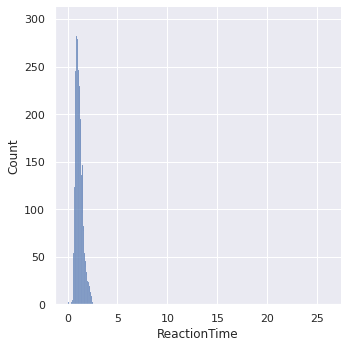

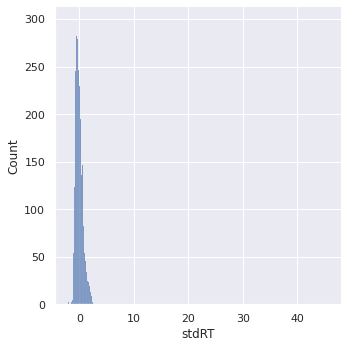

In [89]:
sns.displot(ieeg_short['ReactionTime'])
#pl.xlim([0, 3]);
sns.displot(ieeg_short['stdRT']);

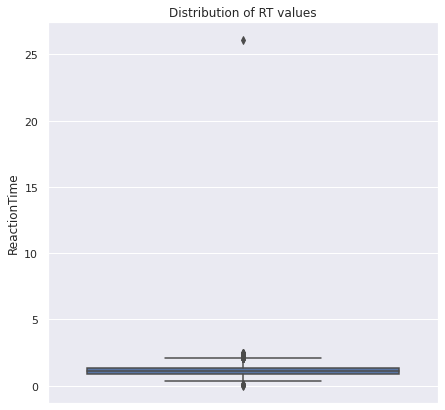

In [90]:
pl.figure(figsize = (7, 7))
ax = sns.boxplot(y="ReactionTime", data=ieeg_short)
pl.title("Distribution of RT values");

In [91]:
# check for outliers outside 
ieeg_no_outliers = ieeg_short.copy()
q75 = np.percentile(ieeg_no_outliers['ReactionTime'], 75)
q25 = np.percentile(ieeg_no_outliers['ReactionTime'], 25)
inter_qr = q75 - q25
upper = q75 + (inter_qr*1.5)
lower = q25 - (inter_qr*1.5)
col_new = []
for value in ieeg_no_outliers['ReactionTime'].values:
  if value < lower:
    col_new.append(np.nan)
  elif value > upper:
    col_new.append(np.nan)
  else:
    col_new.append(value)
ieeg_no_outliers['ReactionTime'] = col_new

In [94]:
print(ieeg_no_outliers.isnull().sum()['ReactionTime'])
# drop outliers
ieeg_no_outliers = ieeg_no_outliers.dropna()
print(ieeg_no_outliers.isnull().sum()['ReactionTime'])

104
0


In [95]:
# redo standardization with new values 
rt = ieeg_no_outliers.ReactionTime.values
ieeg_no_outliers['stdRT'] = (rt - rt.mean())/rt.std()

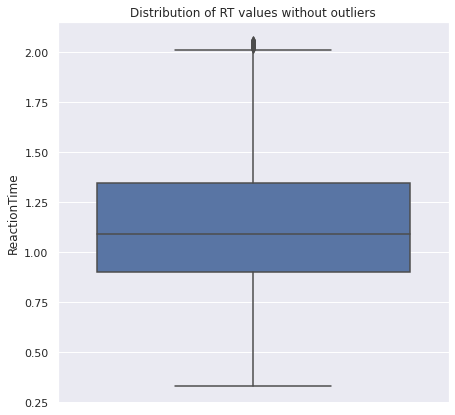

In [97]:
pl.figure(figsize = (7, 7))
ax = sns.boxplot(y="ReactionTime", data=ieeg_no_outliers)
pl.title("Distribution of RT values without outliers");

<Figure size 1440x720 with 0 Axes>

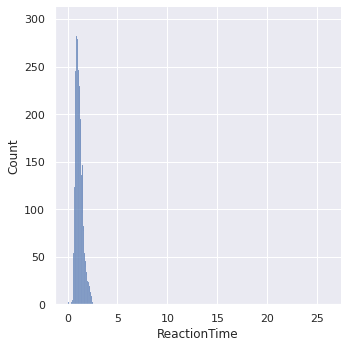

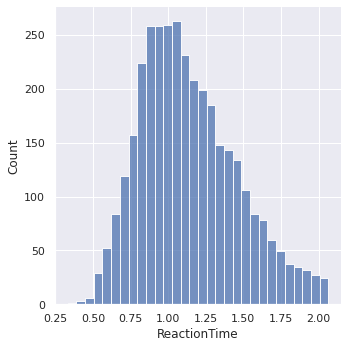

In [98]:
# upper plot - with outliers, lower plot - without
pl.figure(figsize = (20, 10))
sns.displot(ieeg_short['ReactionTime']);
sns.displot(ieeg_no_outliers['ReactionTime']);

There are two datasets now: ieeg_short - with outliers in RT, ieeg_no_outliers - without

## Plotting the accuracy across conditions

In [99]:
ieeg_no_outliers.head()

,Trial,Subject,block,ProbeType,probeSound_idx,ProbeTypeName,StimlusCategory,ReactionTime,KeyCode,Resp,RespCorrect,Omission,ProbeCategory,stimulusSounds_idx,Position,Length,stdRT
0,0,D23,1,2,29,in_sequence,Low Words,0.857518,37,Yes,1,Responded,low words,"[29, 25, 30]",1,3,-0.867258
1,1,D23,1,2,5,in_sequence,High Words,1.339604,37,Yes,1,Responded,high words,"[2, 5, 8, 4, 7, 10, 3]",1,7,0.621277
2,2,D23,1,2,16,in_sequence,High Non-Words,1.045657,37,Yes,1,Responded,high non-words,"[19, 14, 18, 16, 20, 15, 17]",2,7,-0.286344
3,3,D23,1,1,29,out_of_sequence,High Words,1.497001,39,No,1,Responded,low words,"[10, 2, 7, 9, 1, 8, 6, 5, 4]",0,9,1.107270
4,4,D23,1,1,9,out_of_sequence,Low Words,1.679783,39,No,1,Responded,high words,"[30, 24, 25, 29, 21]",0,5,1.671646


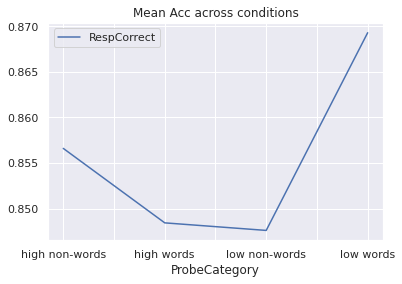

In [100]:
ieeg_no_outliers.groupby(['ProbeCategory'])['RespCorrect'].mean().plot(
    legend=True, title = 'Mean Acc across conditions'
    );

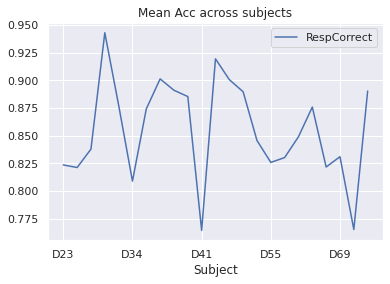

In [101]:
ieeg_no_outliers.groupby(['Subject'])['RespCorrect'].mean().plot(
    legend=True, title = 'Mean Acc across subjects'
    );

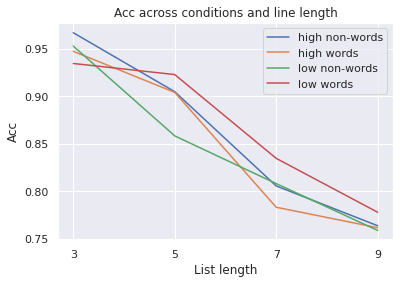

In [102]:
# percentages of correct responses for different conditions
# acc = correct trials in this cond / all trials in this cond
acc_count = lambda v: sum(v) / v.count()
pl.figure()
subset = ieeg_no_outliers.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].apply(
    acc_count
).reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length');  

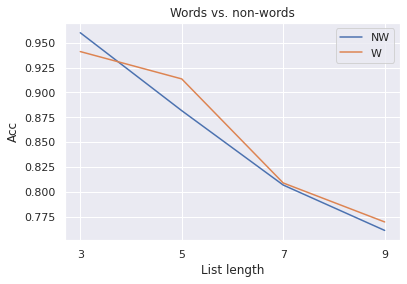

In [103]:
words_nonwords = subset.copy()
new_names = [] 
names = words_nonwords.ProbeCategory.values
for i in names:
  if 'non-words' in i:
    new_names.append('NW')
  elif 'words' in i:
    new_names.append('W')
  else:
    print('Check', i)
    break
words_nonwords['ProbeCategory'] = new_names

pl.figure()
words_nonwords = words_nonwords.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].apply(
    acc_count
). reset_index()
for i in words_nonwords.ProbeCategory.unique():
  x = words_nonwords[words_nonwords['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(words_nonwords.ProbeCategory.unique())
pl.title('Words vs. non-words');  

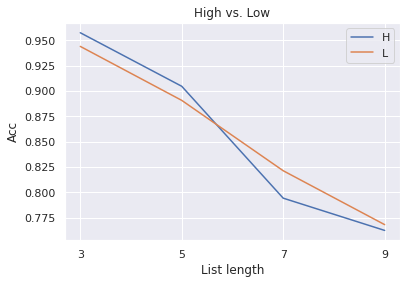

In [104]:
high_low = subset.copy()
new_names = [] 
names = high_low.ProbeCategory.values
for i in names:
  if 'low' in i:
    new_names.append('L')
  elif 'high' in i:
    new_names.append('H')
  else:
    print('Check', i)
    break
high_low['ProbeCategory'] = new_names

pl.figure()
high_low = high_low.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].apply(
    acc_count
). reset_index()
for i in high_low.ProbeCategory.unique():
  x = high_low[high_low['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(high_low.ProbeCategory.unique())
pl.title('High vs. Low'); 

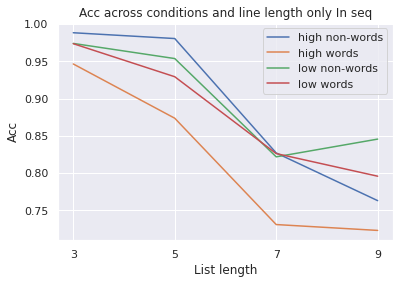

In [105]:
# plotting categories across condition when the probe is in sequence
subset = ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 2]
acc_count = lambda v: sum(v) / v.count()
pl.figure()
subset = subset.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].apply(
    acc_count
).reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length only In seq');  

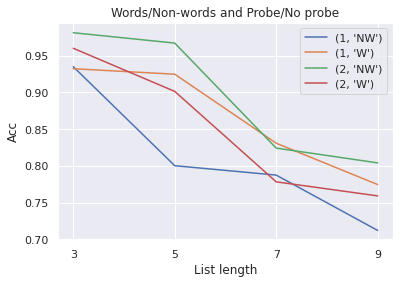

In [108]:
# probe type 2 = in seq, 1 = out of seq
subset = ieeg_no_outliers.groupby(['ProbeType', 'ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
probe_words = subset.copy()
new_cat = []
cat = probe_words.ProbeCategory.values
for i in cat:
  if 'non-words' in i:
    new_cat.append('NW')
  elif 'words' in i:
    new_cat.append('W')
  else:
    print("Check")
probe_words['ProbeCategory'] = new_cat

probe_words = probe_words.groupby(['ProbeType', 'ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in probe_words.ProbeType.unique():
  for j in probe_words.ProbeCategory.unique():
    x = probe_words[(probe_words['ProbeType'] == i) & (probe_words['ProbeCategory'] == j)]
    pl.plot(x.Length, x.RespCorrect, label = (i, j))
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words/Non-words and Probe/No probe');

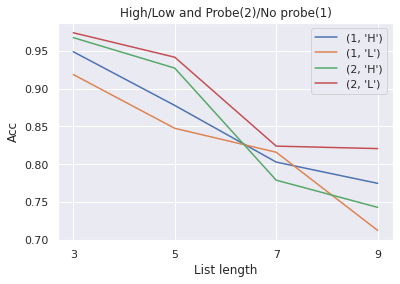

In [110]:
subset = ieeg_no_outliers.groupby(['ProbeType', 'ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
probe_words = subset.copy()
new_cat = []
cat = probe_words.ProbeCategory.values
for i in cat:
  if 'high' in i:
    new_cat.append('H')
  elif 'low' in i:
    new_cat.append('L')
  else:
    print("Check")
probe_words['ProbeCategory'] = new_cat

probe_words = probe_words.groupby(['ProbeType', 'ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in probe_words.ProbeType.unique():
  for j in probe_words.ProbeCategory.unique():
    x = probe_words[(probe_words['ProbeType'] == i) & (probe_words['ProbeCategory'] == j)]
    pl.plot(x.Length, x.RespCorrect, label = (i, j))
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High/Low and Probe(2)/No probe(1)');

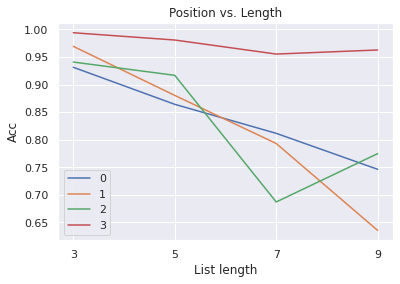

In [111]:
subset = ieeg_no_outliers.groupby(['Position', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Position.unique():
  x = subset[subset['Position'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.Position.unique())
pl.title('Position vs. Length');

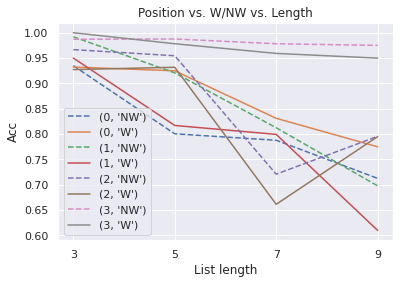

In [112]:
subset = ieeg_no_outliers.groupby(['Position', 'Length', 'ProbeCategory'])[['RespCorrect']].mean().reset_index()
pos_words = subset.copy()
new_cat = []
cat = pos_words.ProbeCategory.values
for i in cat:
  if 'non-words' in i:
    new_cat.append('NW')
  elif 'words' in i:
    new_cat.append('W')
  else:
    print("Check")
pos_words['ProbeCategory'] = new_cat

pos_words = pos_words.groupby(['Position', 'ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()

for i in pos_words.Position.unique():
  for j in pos_words.ProbeCategory.unique():
    x = pos_words[(pos_words['Position'] == i) & (pos_words['ProbeCategory'] == j)]
    if j == 'NW':
      pl.plot(x.Length, x.RespCorrect, '--', label = (i, j))
    elif j == 'W':
      pl.plot(x.Length, x.RespCorrect, label = (i, j))
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Position vs. W/NW vs. Length');

## Plotting the RT across conditions

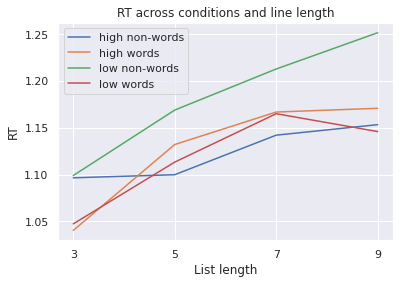

In [114]:
subset = ieeg_no_outliers.groupby(['ProbeCategory', 'Length'])[['ReactionTime']].mean().reset_index()
pl.figure()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ReactionTime)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.ProbeCategory.unique())
pl.title('RT across conditions and line length'); 

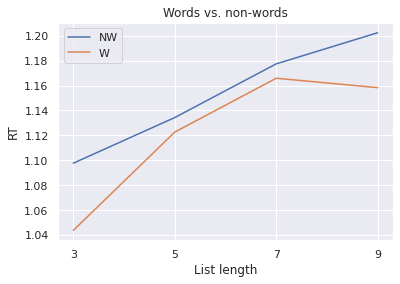

In [115]:
words_nonwords = subset.copy()
new_names = [] 
names = words_nonwords.ProbeCategory.values
for i in names:
  if 'non-words' in i:
    new_names.append('NW')
  elif 'words' in i:
    new_names.append('W')
  else:
    print('Check', i)
    break
words_nonwords['ProbeCategory'] = new_names

pl.figure()
words_nonwords = words_nonwords.groupby(['ProbeCategory', 'Length'])[['ReactionTime']].mean().reset_index()
for i in words_nonwords.ProbeCategory.unique():
  x = words_nonwords[words_nonwords['ProbeCategory'] == i]
  pl.plot(x.Length, x.ReactionTime)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(words_nonwords.ProbeCategory.unique())
pl.title('Words vs. non-words');  

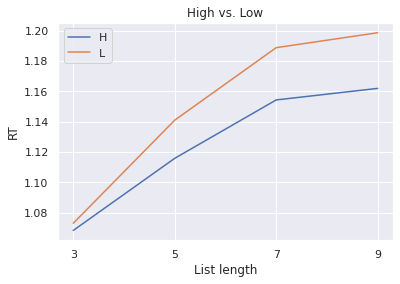

In [116]:
high_low = subset.copy()
new_names = [] 
names = high_low.ProbeCategory.values
for i in names:
  if 'low' in i:
    new_names.append('L')
  elif 'high' in i:
    new_names.append('H')
  else:
    print('Check', i)
    break
high_low['ProbeCategory'] = new_names

pl.figure()
high_low = high_low.groupby(['ProbeCategory', 'Length'])[['ReactionTime']].mean().reset_index()
for i in high_low.ProbeCategory.unique():
  x = high_low[high_low['ProbeCategory'] == i]
  pl.plot(x.Length, x.ReactionTime)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(high_low.ProbeCategory.unique())
pl.title('High vs. Low');  

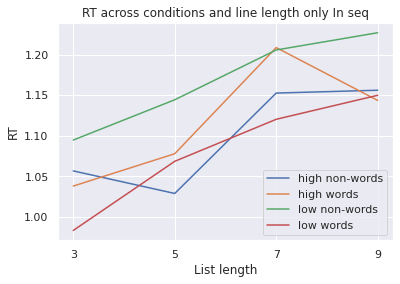

In [117]:
# plotting categories across condition when the probe is in sequence
subset = ieeg_no_outliers[eeg_no_outliers['ProbeType'] == 2]
pl.figure()
subset = subset.groupby(['ProbeCategory', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ReactionTime)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.ProbeCategory.unique())
pl.title('RT across conditions and line length only In seq');

## Analysis